In [8]:
from src.dl_data_pipeline.validator import TypeValidator, ShapeValidator, MinMaxValidator, MeanVarValidator
from src.dl_data_pipeline.pipeline.pipe_node import PipelineNode
from src.dl_data_pipeline.pipeline.data_pipeline import Pipeline
from src.dl_data_pipeline import deferred_execution, InputNode
from src.dl_data_pipeline.process_functions import (any_process, process_2d)
from scipy.signal import convolve2d
import numpy as np


@deferred_execution
def nearest(data: np.ndarray, nshape: tuple):
    new_height, new_width = nshape

    # Get the original dimensions
    old_height, old_width = data.shape[:2]
    
    # Create an empty array for the resized image
    resized_image = np.zeros((new_height, new_width, *data.shape[2:]), dtype=data.dtype)

    # Calculate the scale ratios
    row_ratio = old_height / new_height
    col_ratio = old_width / new_width

    # Iterate over the new image dimensions and assign the nearest pixel
    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest pixel in the original image
            nearest_row = int(i * row_ratio)
            nearest_col = int(j * col_ratio)

            # Assign the pixel value to the resized image
            resized_image[i, j] = data[nearest_row, nearest_col]
    
    return resized_image

def cubic_weight(t):
    # Cubic weight function used in bicubic interpolation
    a = -0.5  # You can adjust this parameter for different smoothing effects
    t = abs(t)
    if t <= 1:
        return (a + 2) * t**3 - (a + 3) * t**2 + 1
    elif t < 2:
        return a * t**3 - 5 * a * t**2 + 8 * a * t - 4 * a
    return 0

@deferred_execution
def bicubic(data: np.ndarray, nshape: tuple):
    old_height, old_width = data.shape[:2]
    new_height, new_width = nshape
    channels = data.shape[2] if len(data.shape) == 3 else 1
    
    # Initialize output image
    resized_image = np.zeros((new_height, new_width, channels), dtype=data.dtype) if channels > 1 else np.zeros((new_height, new_width), dtype=data.dtype)
    
    row_ratio = old_height / new_height
    col_ratio = old_width / new_width

    def get_pixel_value(img, x, y, c):
        # Handle out of bounds by clamping to image edges
        x = max(0, min(old_height - 1, x))
        y = max(0, min(old_width - 1, y))
        return img[x, y, c] if channels > 1 else img[x, y]

    for i in range(new_height):
        for j in range(new_width):
            # Map output pixel to the input image coordinates
            x = i * row_ratio
            y = j * col_ratio
            x_floor = int(np.floor(x))
            y_floor = int(np.floor(y))
            
            for c in range(channels):  # Loop through each channel
                pixel_value = 0
                # Sum over a 4x4 grid
                for m in range(-1, 3):
                    for n in range(-1, 3):
                        pixel_value += get_pixel_value(data, x_floor + m, y_floor + n, c) * \
                                       cubic_weight(x - (x_floor + m)) * \
                                       cubic_weight(y - (y_floor + n))
                
                # Assign the computed value to the output image
                resized_image[i, j, c] = np.clip(pixel_value, 0, 255) if channels > 1 else np.clip(pixel_value, 0, 255)
    
    return resized_image



input1 = PipelineNode(name = "1")
x = process_2d.open_rgb_image(input1)
x = any_process.rescale(x, 0, 1)
x = process_2d.resize_with_max_distortion(x, (256, 256), 0.2)
x = process_2d.padding_2d(x, (256, 256), 0)
out1 = process_2d.max_pooling_2d(x, 4)
out2 = process_2d.avg_pooling_2d(x, 4)
out3 = process_2d.any_pooling_2d(x, 4, pooling_function=np.median)

pipe = Pipeline(input1, [x, out1, out2, out3])

pipe.add_validator(TypeValidator(np.ndarray), 0)
pipe.add_validator(TypeValidator(np.ndarray), 1)

pipe.add_validator(ShapeValidator((256, 256, 3)), 0)
pipe.add_validator(ShapeValidator((64, 64, 3)), 1)



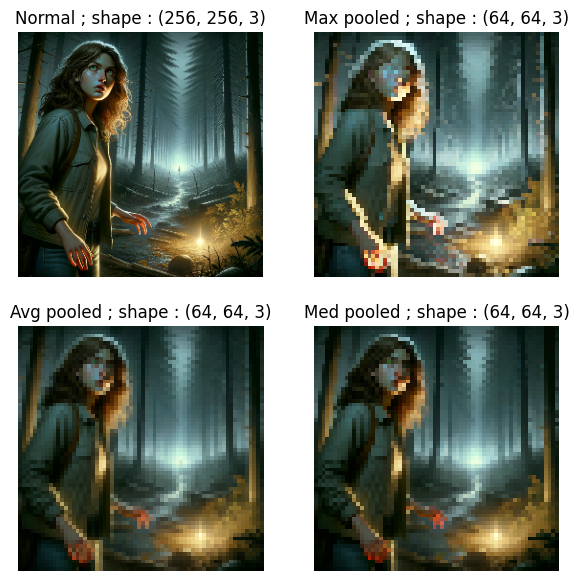

In [9]:
import matplotlib.pyplot as plt
path = "../DailyHorrorStory/images_test/my_img_hd2.png"

_,ax = plt.subplots(2,2, figsize=(7,7))

ax = ax.flatten()
[a.set_axis_off() for a in ax]

normal, max_p, mean_p, min_p = pipe(path)

ax[0].set_title(f"Normal ; shape : {normal.shape}")
ax[0].imshow(normal)

ax[1].set_title(f"Max pooled ; shape : {max_p.shape}")
ax[1].imshow(max_p)

ax[2].set_title(f"Avg pooled ; shape : {mean_p.shape}")
ax[2].imshow(mean_p)

ax[3].set_title(f"Med pooled ; shape : {min_p.shape}")
ax[3].imshow(min_p)
plt.show()

In [1]:
from src.dl_data_pipeline.pipeline import PipelineNode, Pipeline
a = PipelineNode()
x = a[0]
y = a[1]
pipe = Pipeline(a, [x, y])

In [12]:
pipe((0,1))
p = lambda x : x
p.__name__

'<lambda>'

In [11]:
class Test:
    def __getitem__(self, key):
        print(key)

a = Test()


(slice(1, 2, 1), 2, 123)


In [4]:
# Import lib
from dl_data_pipeline import Pipeline, InputNode, deferred_execution
# Create input nodes
input_node1 = InputNode(name="1")   # InputNode base name is input, it then concatenate
input_node2 = InputNode(name="2")   # Any subname passed by user
# use any function, you can also create one
@deferred_execution
def sum(v1, v2):
    return v1 + v2
# create a functional PipelineNode with this function
add_node = sum(input_node1, input_node2)
# Create a pipeline
pipeline = Pipeline(inputs=[input_node1, input_node2], outputs=add_node)
# Compute pipe
pipeline(20, 10) # will be 30

30